In [4]:
import numpy as np
from matplotlib import pyplot as plt
import RandomFeatures as rf
from scipy.optimize import minimize_scalar
import pickle

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
num_features = 2**12 + 1
num_train = 50
num_test = 100

num_features_tested = [2**k for k in range(1,5)]# 13)]
r_scale = 20

In [13]:
#func = lambda y, random, a, b: a + b * y + random * r_scale
func = lambda y, noise, a, b, c: a + b*y + c*np.sin(y) + noise*r_scale

In [14]:
param_generator = rf.random_features(func, 3, num_features)

In [15]:
training_ys_array = np.random.normal(10, 20, num_train)
training_xs_array = param_generator.get_xs(training_ys_array)
testing_ys_array = np.random.normal(10, 20, num_test)
testing_xs_array = param_generator.get_xs(testing_ys_array)

training_xs = torch.tensor(training_xs_array, dtype = torch.float32)
training_ys = torch.tensor(training_ys_array, dtype = torch.float32)
testing_xs = torch.tensor(testing_xs_array, dtype = torch.float32)
testing_ys = torch.tensor(testing_ys_array, dtype = torch.float32)

In [16]:
baseline = nn.MSELoss()(torch.ones_like(testing_ys) * torch.mean(training_ys), testing_ys).item()

In [17]:
numbers_of_layers = [1, 2, 3, 4, 5]
colors_for_layers = ['red','orange','yellow','green','blue']
relu_on = False


1 layers
	Features used: 2
	Training loss: 207.33111572265625
	Testing loss: 277.4415588378906

	Features used: 4
	Training loss: 80.97419738769531
	Testing loss: 113.73628997802734

	Features used: 8
	Training loss: 38.1274528503418
	Testing loss: 75.20449829101562

	Features used: 16
	Training loss: 13.763391494750977
	Testing loss: 36.207435607910156


2 layers
	Features used: 2
	Training loss: 207.64146423339844
	Testing loss: 277.4521789550781

	Features used: 4
	Training loss: 81.05530548095703
	Testing loss: 113.98622131347656

	Features used: 8
	Training loss: 38.1685905456543
	Testing loss: 75.71647644042969

	Features used: 16
	Training loss: 13.594178199768066
	Testing loss: 36.49250030517578


3 layers
	Features used: 2
	Training loss: 210.52906799316406
	Testing loss: 280.3577880859375

	Features used: 4
	Training loss: 81.46035766601562
	Testing loss: 111.54722595214844

	Features used: 8
	Training loss: 38.3944206237793
	Testing loss: 76.83418273925781

	Features used: 

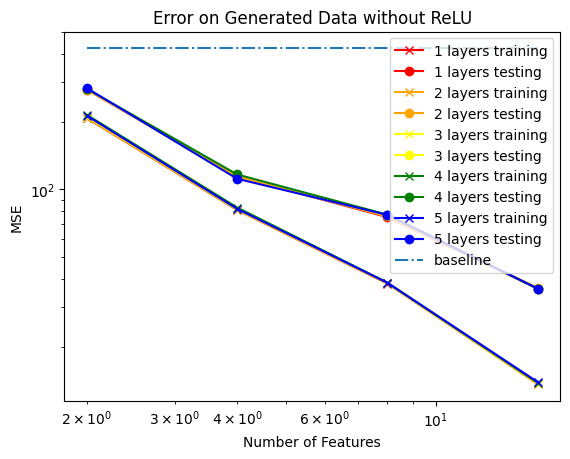

In [21]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)

for num_layers, my_color in zip(numbers_of_layers, colors_for_layers):
    training_losses = []
    testing_losses = []
    print("\n{} layers".format(num_layers))
    for features_used in num_features_tested:
        if num_layers == 1:
            model = nn.Linear(features_used, 1)
        else:
            steps = [nn.Linear(features_used, 100)]
            for _ in range(num_layers - 2):
                if relu_on:
                    steps = steps + [nn.ReLU(), nn.Linear(100, 100)]
                else:
                    steps = steps + [nn.Linear(100, 100)]
            if relu_on:
                steps = steps + [nn.ReLU(), nn.Linear(100, 1)]
            else:
                steps = steps + [nn.Linear(100, 1)]
            model = nn.Sequential(*steps)

        used_training_xs = training_xs[:,:features_used]
        used_testing_xs = testing_xs[:,:features_used]

        for _ in range(10000):
            opt = optim.Adam(model.parameters(), lr = 1e-3 / features_used)
            loss = nn.MSELoss()(torch.flatten(model(used_training_xs)), training_ys)
            loss.backward()
            opt.step()
            opt.zero_grad()
        training_losses.append(loss.item())
        testing_losses.append(nn.MSELoss()(torch.flatten(model(used_testing_xs)), testing_ys).item())

        print("\tFeatures used: {}".format(features_used))
        print("\tTraining loss: {}".format(training_losses[-1]))
        print("\tTesting loss: {}".format(testing_losses[-1]))
        print()

    ax.loglog(num_features_tested, training_losses, color=my_color, marker='x', label = "{} layers training".format(num_layers))
    ax.loglog(num_features_tested, testing_losses, color=my_color, marker='o', label = "{} layers testing".format(num_layers))

ax.loglog(num_features_tested, np.ones_like(num_features_tested) * baseline, '-.', label = 'baseline')

plt.legend()
plt.xlabel("Number of Features")
plt.ylabel("MSE")
if relu_on:
    plt.title("Error on Generated Data")
else:
    plt.title("Error on Generated Data without ReLU")
plt.show()